In [1]:
# Package Imports
import maboss
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil


ipylab module is not installed, menus and toolbar are disabled.


In [2]:
# Helper and script imports
import sys
sys.path.append("/Users/emilieyu/endotehelial-masboss")
from boolean_models.scripts.run_wt_single import main
from boolean_models.analysis import (
    generate_ko_models,
    compute_delta,
    classify_phenotype,
    generate_ko_names,
    save_df_to_csv
)

from boolean_models.scripts.run_kos_single import extract_steady_state

In [3]:
# Set project root dir
PROJECT_ROOT = Path("/Users/emilieyu/endotehelial-masboss/")
MODELS_DIR = PROJECT_ROOT / "boolean_models" / "models"
RESULTS_DIR = PROJECT_ROOT / "results" / "boolean_models" / "rho_test"/ "ko_single"

# load model and WT configuration
model_file = MODELS_DIR / "rho.bnd"
cfg_file   = MODELS_DIR / "rho_base.cfg"

model = maboss.load(str(model_file), str(cfg_file))
nodes = ['DSP', 'TJP1', 'JCAD']

raw_dir = RESULTS_DIR / "raw"
processed_dir = RESULTS_DIR / "processed"
ss_dir = RESULTS_DIR / "steady_state"

fig_time_dir = RESULTS_DIR / "figures_timecourse"
fig_ss_dir = RESULTS_DIR / "figures_steady_state"

# raw_dir.mkdir(parents=True, exist_ok=True)
# processed_dir.mkdir(parents=True, exist_ok=True)

fig_time_dir.mkdir(parents=True, exist_ok=True)
fig_ss_dir.mkdir(parents=True, exist_ok=True)



### Reminder: Basic Perturbation Behaviour Validation

Generate perturbation scenarios, run perturbations, and store raw output

In [ ]:
ko_scenarios = generate_ko_models(model, nodes)

In [ ]:
def save_sim_details(result, result_directory, perb_name):
    # Save node probabilities
    nodes_probtraj = result.get_nodes_probtraj().rename_axis('t').reset_index()    
    nodes_probtraj.to_csv(
        result_directory / f"{perb_name}_nodes_probtraj.csv",
        index=False
    )

    # Save state probabilities
    states_probtraj = result.get_states_probtraj().rename_axis('t').reset_index()    
    states_probtraj.to_csv(
        result_directory / f"{perb_name}_states_probtraj.csv",
        index=False
    )


In [ ]:
perb_dict = {}
phenotype_dict = {}

# Run simulations. 
for name, model in ko_scenarios.items():
    print(f"DEBUG: Running scenario: {name}")

    res_dir = RESULTS_DIR / "rho_model" / name
    
    # Ensure clean output directory
    if res_dir.exists():
        shutil.rmtree(res_dir)
    res_dir.mkdir(parents=True, exist_ok=True)

    # Run MaBoSS
    res = model.run()

    prob_df = res.get_nodes_probtraj()

    # Save raw simulation details
    save_sim_details(res, res_dir, name)
    
    # Compute Rho balance
    balance_df = prob_df.copy().rename_axis('t').reset_index()   
    balance_df["delta"] = compute_delta(balance_df)
    perb_dict[name] = balance_df

    # Compute raw phenotypes
    phenotype_df = classify_phenotype(balance_df).rename_axis('t').reset_index()   
    phenotype_dict[name] = phenotype_df

    # Compute raw phenotypes
    print(f"DEBUG: Writing intermediate data to file for: {name}")
    balance_df.to_csv(res_dir / f"{name}_phenotype.csv")
    phenotype_df.to_csv(res_dir / f"{name}_phenotype.csv")


In [ ]:
tjp1 = perb_dict['TJP1_ko']
tjp1

### Refactoring

In [ ]:
# Generate KO Perturbation
ko_scenarios = generate_ko_models(model, nodes)

# Dictionary storing node probability + delta trajectories
perb_dict = {}
phenotype_dict = {}

# Run simulations. 
for name, model in ko_scenarios.items():

    # Run MaBoSS
    res = model.run()

    # Basic sanity check
    prob_df = res.get_nodes_probtraj().rename_axis('t')
    save_df_to_csv(prob_df, raw_dir, f"{name}_nodes_probraj.csv")
    
    # Compute Rho balance
    balance_df = prob_df.copy()  
    balance_df["delta"] = compute_delta(balance_df)
    save_df_to_csv(balance_df, processed_dir, f"{name}_balance.csv")

    perb_dict[name] = balance_df

    # Compute raw phenotypes
    phenotype_df = classify_phenotype(balance_df, eps=0.20)  
    save_df_to_csv(phenotype_df, processed_dir, f"{name}_phenotype.csv")

    phenotype_dict[name] = phenotype_df


# Compute and save combined steady state data
balance_concat_df = extract_steady_state(perb_dict)
pheno_concat_df = extract_steady_state(phenotype_dict)

save_df_to_csv(balance_concat_df, processed_dir, f"steady_state_balance.csv")
save_df_to_csv(pheno_concat_df, processed_dir, f"steady_state_phenotype.csv")


In [ ]:
balance_concat_df

In [ ]:
pheno_concat_df

### Timecourse Plotting

In [ ]:
balance_files = processed_dir.glob("*balance.csv")
perbs_dict = {}

for file_path in balance_files:
    #print(file_path)
    # extract file name only and replace
    name = file_path.stem.replace("_balance", "")
    
    # Read CSV without adding new index
    df = pd.read_csv(file_path, index_col=[0])
    
    perbs_dict[name] = df

perbs_dict['WT']

In [ ]:
def plot_rhos(name, df, save=False, outdir=None, show=True):
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(df["RhoA"], label="RhoA")
    ax.plot(df["RhoC"], label="RhoC")

    ax.set_title(f"{name}: RhoA / RhoC activation")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

    fig.tight_layout()

    if save and outdir is not None:
        outpath = outdir / f"{name}_rho_activation_prob.png"
        fig.savefig(outpath, dpi=300)

    if show: 
        plt.show()

    plt.close(fig)
    return fig


def plot_delta(name, df, eps=0.20, save=False, outdir=None, show=True):
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(df.index, df["delta"], label="Δ(t)")

    ax.axhline(eps, linestyle="--", label="+ε", color='red')
    ax.axhline(-eps, linestyle="--", label="-ε", color='red')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_ylim(-0.5, 0.5)
    ax.set_title(f"{name} – Rho balance")
    ax.set_xlabel("Time")
    ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
    ax.legend()

    plt.tight_layout()

    if save and outdir is not None:
        outpath = outdir / f"{name}_delta_time.png"
        fig.savefig(outpath, dpi=300)

    if show: 
        plt.show()
        
    plt.close(fig)
    return fig

In [ ]:
for name, df in perbs_dict.items(): 
    plot_rhos(name, df, True, fig_time_dir, False)
    plot_delta(name, df, 0.2, True, fig_time_dir, False)

### Steady State Plotting

In [12]:
def plot_full_ss(df, eps=0.25, save=False, outdir=None, show=True):
    fig, ax = plt.subplots(figsize=(6,4))

    df["delta"].plot(kind="bar", ax=ax)

    ax.axhline(eps, linestyle="--", label="+ε", color='red')
    ax.axhline(-eps, linestyle="--", label="-ε", color='red')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_ylabel("Steady-state Δ")
    ax.set_title("Steady-state Rho balance across perturbations")
    ax.legend()

    plt.tight_layout()
    plt.show()

    if save and outdir is not None:
        outpath = outdir / "ss_rho_thresh.png"
        fig.savefig(outpath, dpi=300)

    if show: 
        plt.show()

    plt.close(fig)

In [14]:
ss_dict = {}

# Extract data
for file_path in ss_dir.iterdir(): 
    name = file_path.stem.replace("steady_state_", "")
    df = pd.read_csv(file_path, index_col=[0])
    ss_dict[name] = df

# Assign to pd dataframes for processing
pheno_df = ss_dict['phenotype']
balance_df = ss_dict['balance']

# Reshape: melt phenotype df
pheno_df_long = df.melt(id_vars="scenario", 
                  value_vars=["Failed", "Hyper", "Normal"], 
                  var_name="phenotype", 
                  value_name="value")
pheno_df_final = pheno_df_long[pheno_df_long["value"] == 1].drop(columns="value").reset_index(drop=True)
pheno_df_final


,scenario,phenotype
0,TJP1,Failed
1,DSP,Hyper
2,WT,Normal
3,JCAD,Normal
4,DSP_TJP1,Normal
5,DSP_JCAD,Normal
6,TJP1_JCAD,Normal


In [18]:

# combine all ss results into 1 df
merged = pheno_df_final.merge(
    balance_df[['scenario', 'delta']],
    on="scenario",
    how="left"
).set_index('scenario')

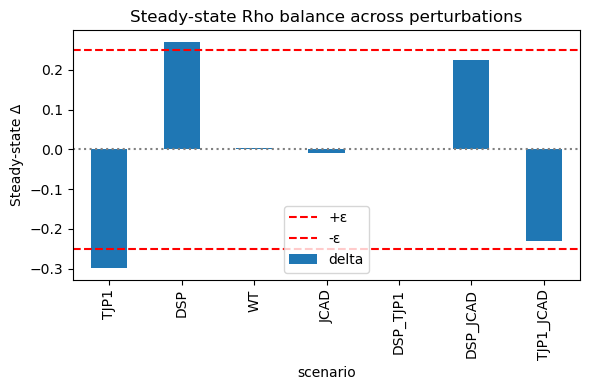

In [19]:

# plot and save
plot_full_ss(merged, 0.25, True, fig_ss_dir)

In [10]:
# Save dataframe table as figure

table_df = merged.copy().round(3)
table_df.columns = [col.capitalize() for col in table_df.columns]
table_df

,Scenario,Phenotype,Delta
0,TJP1,Failed,-0.300
1,DSP,Hyper,0.271
2,WT,Normal,0.002
3,JCAD,Normal,-0.008
4,DSP_TJP1,Normal,0.002
5,DSP_JCAD,Normal,0.224
6,TJP1_JCAD,Normal,-0.231


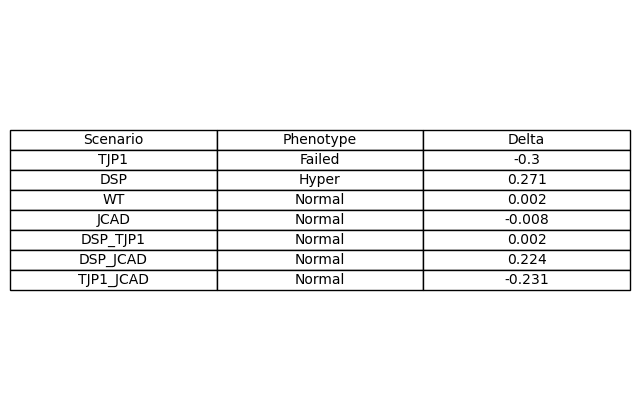

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(8, len(df) * 0.6 + 1))
ax.axis('off')

# Create table
table = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

# Save figure
plt.savefig(fig_ss_dir / "pheno_delta_table.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)